In [1]:
# imports
from gensim.parsing.preprocessing import remove_stopwords
from dotenv import load_dotenv
import json
import numpy as np
import os
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 

unable to import 'smart_open.gcs', disabling that module


In [9]:
load_dotenv()

DB_USER = os.getenv("DB_USER") 
DB_PASSWORD = os.getenv("DB_PASSWORD") 
HOST = os.getenv("HOST") 
PORT = os.getenv("PORT") 
DB_NAME = os.getenv("DB_NAME") 

# Connect to the database
connection = psycopg2.connect(user=DB_USER,
                            password=DB_PASSWORD,
                            host=HOST,
                            port=PORT,
                            database=DB_NAME)

cursor = connection.cursor()

In [3]:
# Header
def get_header(user_id=None):
    try:
        header_chart = []
        each_chart = {}
        
        # Total ratings
        query = f'SELECT COUNT(*) FROM user_ratings WHERE user_id={user_id}'
        cursor.execute(query)
        total_ratings = cursor.fetchall()[0][0]
        each_chart['label'] = 'ratings'
        each_chart['measure'] = total_ratings
        header_chart.append(each_chart)
    
        # Total reviews
        each_chart = {}
        query = f'SELECT COUNT(*) FROM user_reviews WHERE user_id={user_id}'
        cursor.execute(query)
        total_reviews = cursor.fetchall()[0][0]
        each_chart['label'] = 'reviews'
        each_chart['measure'] = total_reviews
        header_chart.append(each_chart)
        
        # Total watched
        each_chart = {}
        query = f'SELECT COUNT(*) FROM user_watched WHERE user_id={user_id} GROUP BY user_id'
        cursor.execute(query)
        total_watched = cursor.fetchall()[0][0]
        each_chart['label'] = 'movies watched'
        each_chart['measure'] = total_watched
        header_chart.append(each_chart)
        
        # Watchlist
        each_chart = {}
        query = f'SELECT COUNT(*) FROM user_watchlist WHERE user_id={user_id}'
        cursor.execute(query)
        total_watchlist = cursor.fetchall()[0][0]
        each_chart['label'] = 'movies added to watchlist'
        each_chart['measure'] = total_watchlist
        header_chart.append(each_chart)
        
        return json.dumps(header_chart)

    except Exception as e:
        print(e)
        return json.dumps({"message": "OOPS Something went wrong", "details": str(e)})

get_header(312517)

'[{"label": "ratings", "measure": 805}, {"label": "reviews", "measure": 79}, {"label": "movies watched", "measure": 1140}, {"label": "movies added to watchlist", "measure": 1043}]'

![alt text](img/header.png)

In [5]:
# Best rated movies
def get_best_rated():
    try:
        query = """
            SELECT t.movie_id, t.primary_title, t.start_year, t.genres, t.poster_url,
                ((COALESCE(t.imdb_rating,0) + COALESCE(t.avg_usr_rating,0)) / 
                    NULLIF((CASE WHEN t.imdb_rating IS NULL THEN 0 ELSE 1 END + 
                            CASE WHEN t.avg_usr_rating IS NULL THEN 0 ELSE 1 END),0)
                ) AS average
            FROM (
                SELECT m.movie_id, m.primary_title, m.start_year, m.genres, m.poster_url,
                    m.average_rating AS imdb_rating, AVG(ur.rating) AS avg_usr_rating
                FROM movies m LEFT JOIN user_ratings ur ON m.movie_id=ur.movie_id
                GROUP BY m.movie_id) t
            ORDER BY average DESC NULLS LAST
            LIMIT 30;
        """
        cursor.execute(query)
        best_rated = cursor.fetchall()
        title=[]
        year=[]
        genres=[]
        poster_url=[]
        rating=[]
        best_rated_data = []
        keys=range(30)

        for row in best_rated:
            title.append(row[1])
            year.append(row[2])
            genres.append(row[3])
            poster_url.append(row[4])
            rating.append(row[5])

        for i in keys:
            each_data={}
            each_data['rank'] = i+1
            each_data['title'] = title[i]
            each_data['year'] = year[i]
            each_data['genres'] = genres[i]
            each_data['poster_url'] = poster_url[i]
            each_data['rating'] = rating[i]
            best_rated_data.append(each_data)

        return json.dumps(best_rated_data)

    except Exception as e:
        print(e)
        return json.dumps({"message": "OOPS Something went wrong", "details": str(e)})

get_best_rated()

'[{"rank": 1, "title": "Cursed Be the Phosphate", "year": 2012, "genres": "Documentary", "poster_url": null, "rating": 5.0}, {"rank": 2, "title": "A Part of Me", "year": 2018, "genres": "Drama", "poster_url": "/f9IJ7cp8pds75QYa17bCgm5NNZT.jpg", "rating": 5.0}, {"rank": 3, "title": "El Gort", "year": 2014, "genres": "Documentary", "poster_url": null, "rating": 5.0}, {"rank": 4, "title": "7\\u00bd", "year": 2014, "genres": "Documentary", "poster_url": null, "rating": 5.0}, {"rank": 5, "title": "Moghamarat Dalila al-Makira", "year": 2016, "genres": "Adventure,Animation,Drama", "poster_url": null, "rating": 5.0}, {"rank": 6, "title": "D\\u00e9gage", "year": 2012, "genres": "Documentary", "poster_url": null, "rating": 5.0}, {"rank": 7, "title": "Rainaldo Graziani da Meridiano Zero al Soggetto Radicale... da Evola a Dugin", "year": 2019, "genres": "Documentary", "poster_url": null, "rating": 5.0}, {"rank": 8, "title": "Behind the Wave", "year": 2016, "genres": "Documentary", "poster_url": nu

![alt text](img/best_rated.png)

In [7]:
# Last 10 reviews
# takes only first 50 characters of the review_text
def last_reviews():
    try:
        query = """
            SELECT DISTINCT m.poster_url, m.primary_title, CONCAT(LEFT(ur.review_text, 50), '...'), ur.date
            FROM user_reviews ur INNER JOIN movies m ON ur.movie_id=m.movie_id
            ORDER BY ur.date DESC
            LIMIT 10;
            """
        cursor.execute(query)
        last_reviews = cursor.fetchall()
        
        poster_url=[]
        title=[]
        review_text=[]
        date=[]
        last_reviews_data = []
        keys=range(10)

        for row in last_reviews:
            poster_url.append(row[0])
            title.append(row[1])
            review_text.append(row[2])
            date.append(row[3])

        for i in keys:
            each_data={}
            each_data['position'] = i+1
            each_data['title'] = title[i]
            each_data['poster_url'] = poster_url[i]
            each_data['review_text'] = review_text[i]
            each_data['date'] = date[i].strftime("%m/%d/%Y")
            last_reviews_data.append(each_data)

        return json.dumps(last_reviews_data)
    
    except Exception as e:
        print(e)
        return json.dumps({"message": "OOPS Something went wrong", "details": str(e)})

last_reviews()

'[{"position": 1, "title": "Bee Movie", "poster_url": "/rYBaXgvTKFS8iZC7Wr8SMomSauQ.jpg", "review_text": "Masterpiece. Perfect. 10/10....", "date": "03/05/2020"}, {"position": 2, "title": "Replicas", "poster_url": "/hhPBTAn9b4TYOxc1JYNsX4BFAlW.jpg", "review_text": "I love cloning technology mixed with brain uploadi...", "date": "02/23/2020"}, {"position": 3, "title": "Sleeping Beauty", "poster_url": "/j4YBuAe8D1jDSiitpq69og9x3Yl.jpg", "review_text": "As a kid, I watched this movie dozens, maybe a hun...", "date": "01/03/2020"}, {"position": 4, "title": "Sleeping Beauty", "poster_url": "/j4YBuAe8D1jDSiitpq69og9x3Yl.jpg", "review_text": "Really nostalgic for this movie. The balletic scor...", "date": "01/03/2020"}, {"position": 5, "title": "Midsommar", "poster_url": "/7LEI8ulZzO5gy9Ww2NVCrKmHeDZ.jpg", "review_text": "Way funnier than I expected. A lot of people will ...", "date": "07/12/2019"}, {"position": 6, "title": "Hereditary", "poster_url": "/lHV8HHlhwNup2VbpiACtlKzaGIQ.jpg", "revi

![alt text](img/last_reviews.png)

In [11]:
# Favorite genres
def favorite_genres(user_id=None):
    try:
        query = f'SELECT genres FROM user_ratings ur INNER JOIN movies m ON ur.movie_id=m.movie_id WHERE user_id={user_id} AND rating>3'
        cursor.execute(query)
        genres = cursor.fetchall()
        genres_list = []

        for row in genres:
            genres_list.append(row[0])

        df = pd.DataFrame({
            'genres':genres_list
        })

        genre_counts = {}
        for genre_string in df['genres'].values:
                genres = genre_string.split(',')
                for genre in genres:
                    each_data = {}
                    if genre in genre_counts:
                        genre_counts[genre] += 1
                    else:
                        genre_counts[genre] = 1
        genre_counts = dict(sorted(genre_counts.items(), key= lambda kv:(kv[1], kv[0]), reverse=True))
        
        genres_list = list(genre_counts.keys())
        values_list = list(genre_counts.values())

        genres_data = []
        for i in range(len(genres_list)):
            each_data = {}
            each_data['genre'] = genres_list[i]
            each_data['measure'] = values_list[i]
            genres_data.append(each_data)

        return json.dumps(genres_data)
    
    except Exception as e:
        print(e)
        return json.dumps({"message": "OOPS Something went wrong", "details": str(e)})

favorite_genres(312517)

'[{"genre": "Drama", "measure": 317}, {"genre": "Comedy", "measure": 163}, {"genre": "Adventure", "measure": 147}, {"genre": "Action", "measure": 131}, {"genre": "Crime", "measure": 107}, {"genre": "Thriller", "measure": 103}, {"genre": "Animation", "measure": 75}, {"genre": "Mystery", "measure": 72}, {"genre": "Fantasy", "measure": 58}, {"genre": "Sci-Fi", "measure": 57}, {"genre": "Horror", "measure": 57}, {"genre": "Romance", "measure": 43}, {"genre": "Family", "measure": 33}, {"genre": "Biography", "measure": 28}, {"genre": "Documentary", "measure": 25}, {"genre": "History", "measure": 15}, {"genre": "War", "measure": 14}, {"genre": "Film-Noir", "measure": 12}, {"genre": "Western", "measure": 11}, {"genre": "Music", "measure": 11}, {"genre": "Sport", "measure": 6}, {"genre": "Musical", "measure": 6}, {"genre": "News", "measure": 1}]'

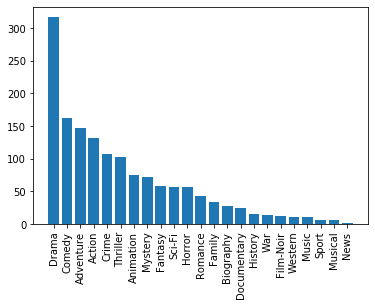

In [12]:
# Visualize
fav_genres = json.loads(favorite_genres(312517))
bar_labels = []
bar_values = []
for i in range(len(fav_genres)):
    bar_labels.append(fav_genres[i]['genre'])
    bar_values.append(fav_genres[i]['measure'])

plt.bar(range(len(fav_genres)), bar_values)
plt.xticks(range(len(fav_genres)), bar_labels, rotation=90)
plt.show()

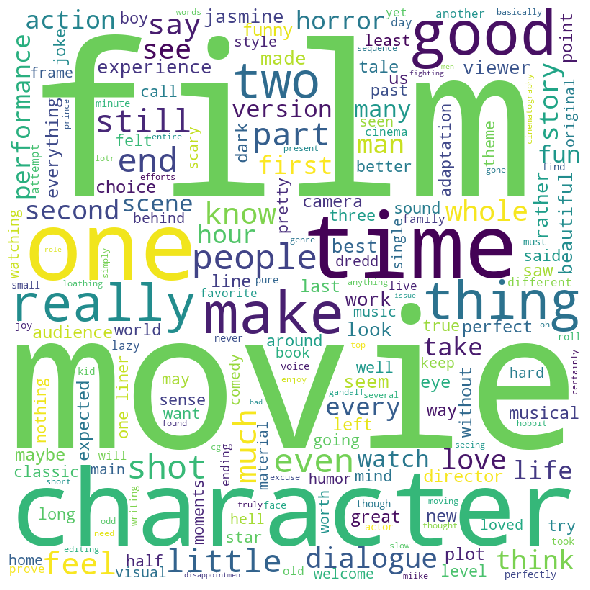

In [13]:
# Most common words used in reviews
user_id = 312517
query = f'SELECT review_text FROM user_reviews WHERE user_id={user_id};'
cursor.execute(query)
result = cursor.fetchall()

reviews_lst = []
for row in result:
    reviews_lst.append(row[0])
reviews = pd.DataFrame({
    'review_text':reviews_lst
})

# Plot the wordcloud
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the df
for val in reviews.review_text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [14]:
# Prefered release years
def favorite_years(user_id=None):
    try:
        query = f'SELECT start_year FROM user_ratings ur INNER JOIN movies m ON ur.movie_id=m.movie_id WHERE user_id={user_id} AND rating>3'
        cursor.execute(query)
        years = cursor.fetchall()

        years_list = []

        for row in years:
            years_list.append(str(row[0]))

        df = pd.DataFrame({
            'years':years_list
        })

        year_counts = {}
        for year in df['years'].values:
            if year in year_counts:
                year_counts[year] += 1
            else:
                year_counts[year] = 1
        year_counts = dict(sorted(year_counts.items(), key=lambda x: x[0]))

        years_list = list(year_counts.keys())
        values_list = list(year_counts.values())

        years_data = []
        for i in range(len(years_list)):
            each_data = {}
            each_data['year'] = years_list[i]
            each_data['measure'] = values_list[i]
            years_data.append(each_data)

        return json.dumps(years_data)

    except Exception as e:
        print(e)
        return json.dumps({"message": "OOPS Something went wrong", "details": str(e)})

favorite_years(312517)

'[{"year": "1922", "measure": 1}, {"year": "1923", "measure": 1}, {"year": "1927", "measure": 2}, {"year": "1928", "measure": 1}, {"year": "1931", "measure": 1}, {"year": "1934", "measure": 1}, {"year": "1935", "measure": 1}, {"year": "1936", "measure": 1}, {"year": "1939", "measure": 2}, {"year": "1940", "measure": 3}, {"year": "1941", "measure": 3}, {"year": "1942", "measure": 2}, {"year": "1944", "measure": 1}, {"year": "1946", "measure": 4}, {"year": "1948", "measure": 3}, {"year": "1949", "measure": 1}, {"year": "1950", "measure": 3}, {"year": "1951", "measure": 3}, {"year": "1952", "measure": 4}, {"year": "1953", "measure": 2}, {"year": "1954", "measure": 3}, {"year": "1955", "measure": 5}, {"year": "1956", "measure": 1}, {"year": "1957", "measure": 5}, {"year": "1958", "measure": 3}, {"year": "1959", "measure": 4}, {"year": "1960", "measure": 5}, {"year": "1961", "measure": 2}, {"year": "1962", "measure": 4}, {"year": "1963", "measure": 3}, {"year": "1964", "measure": 5}, {"year

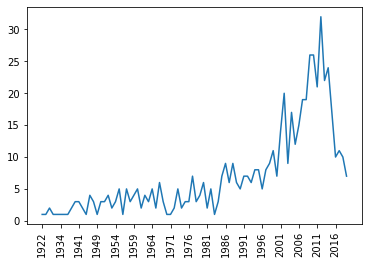

In [17]:
# Visualize
fav_years = json.loads(favorite_years(312517))
line_labels = []
line_values = []
for i in range(len(fav_years)):
    line_labels.append(fav_years[i]['year'])
    line_values.append(fav_years[i]['measure'])
    
plt.plot(line_labels,line_values)
plt.xticks(range(len(fav_years))[0::5], list(line_labels)[0::5], rotation=90)
plt.show()

In [18]:
# Most recommended genres
def recommended_genres(user_id=None):
    try:
        query = """SELECT genres
            FROM recommendations r 
                INNER JOIN recommendations_movies rm ON r.recommendation_id=rm.recommendation_id
                INNER JOIN movies m ON rm.movie_id=m.movie_id
            WHERE user_id="""+f'{user_id}'
        cursor.execute(query)
        rec_genres = cursor.fetchall()

        rec_genres_list = []

        for row in rec_genres:
            rec_genres_list.append(row[0])

        df = pd.DataFrame({
            'genres':rec_genres_list
        })

        rec_genre_counts = {}
        for rec_genre_string in df['genres'].values:
                rec_genres = rec_genre_string.split(',')
                for rec_genre in rec_genres:
                    if rec_genre in rec_genre_counts:
                        rec_genre_counts[rec_genre] += 1
                    else:
                        rec_genre_counts[rec_genre] = 1
        rec_genre_counts = dict(sorted(rec_genre_counts.items(), key= lambda kv:(kv[1], kv[0]), reverse=True))
        
        genres_list = list(rec_genre_counts.keys())
        values_list = list(rec_genre_counts.values())

        genres_data = []
        for i in range(len(genres_list)):
            each_data = {}
            each_data['genre'] = genres_list[i]
            each_data['measure'] = values_list[i]
            genres_data.append(each_data)

        return json.dumps(genres_data)
    
    except Exception as e:
        print(e)
        return json.dumps({"message": "OOPS Something went wrong", "details": str(e)})

recommended_genres(1)

'[{"genre": "Drama", "measure": 129}, {"genre": "Comedy", "measure": 54}, {"genre": "Romance", "measure": 29}, {"genre": "Adventure", "measure": 24}, {"genre": "Action", "measure": 21}, {"genre": "Crime", "measure": 20}, {"genre": "Mystery", "measure": 11}, {"genre": "War", "measure": 10}, {"genre": "Thriller", "measure": 9}, {"genre": "Horror", "measure": 7}, {"genre": "Fantasy", "measure": 7}, {"genre": "Sci-Fi", "measure": 6}, {"genre": "History", "measure": 6}, {"genre": "Film-Noir", "measure": 6}, {"genre": "Music", "measure": 3}, {"genre": "Documentary", "measure": 3}, {"genre": "Family", "measure": 2}]'

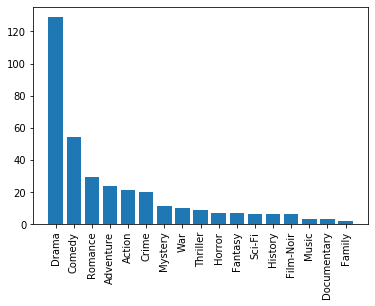

In [22]:
# Visualize
rec_genres = json.loads(recommended_genres(1))
bar_labels = []
bar_values = []
for i in range(len(rec_genres)):
    bar_labels.append(rec_genres[i]['genre'])
    bar_values.append(rec_genres[i]['measure'])

plt.bar(range(len(rec_genres)), bar_values)
plt.xticks(range(len(rec_genres)), bar_labels, rotation=90)
plt.show()

In [20]:
# Most recommended release years
def recommended_years(user_id=None):
    try:
        query = """SELECT start_year
            FROM recommendations r 
                INNER JOIN recommendations_movies rm ON r.recommendation_id=rm.recommendation_id
                INNER JOIN movies m ON rm.movie_id=m.movie_id
            WHERE user_id="""+f'{user_id}'
        cursor.execute(query)
        rec_years = cursor.fetchall()

        rec_years_list = []

        for row in rec_years:
            rec_years_list.append(str(row[0]))

        df = pd.DataFrame({
            'years':rec_years_list
        })

        rec_year_counts = {}
        for rec_year in df['years'].values:
            if rec_year in rec_year_counts:
                rec_year_counts[rec_year] += 1
            else:
                rec_year_counts[rec_year] = 1
        rec_year_counts = dict(sorted(rec_year_counts.items(), key=lambda x: x[0]))

        years_list = list(rec_year_counts.keys())
        values_list = list(rec_year_counts.values())

        years_data = []
        for i in range(len(years_list)):
            each_data = {}
            each_data['year'] = years_list[i]
            each_data['measure'] = values_list[i]
            years_data.append(each_data)

        return json.dumps(years_data)

    except Exception as e:
        print(e)
        return json.dumps({"message": "OOPS Something went wrong", "details": str(e)})
    
recommended_years(1)

'[{"year": "1913", "measure": 6}, {"year": "1916", "measure": 6}, {"year": "1922", "measure": 6}, {"year": "1924", "measure": 1}, {"year": "1925", "measure": 7}, {"year": "1931", "measure": 3}, {"year": "1932", "measure": 1}, {"year": "1950", "measure": 1}, {"year": "1953", "measure": 5}, {"year": "1954", "measure": 8}, {"year": "1956", "measure": 5}, {"year": "1957", "measure": 5}, {"year": "1958", "measure": 5}, {"year": "1959", "measure": 6}, {"year": "1960", "measure": 5}, {"year": "1961", "measure": 3}, {"year": "1966", "measure": 1}, {"year": "1968", "measure": 7}, {"year": "1969", "measure": 1}, {"year": "1970", "measure": 11}, {"year": "1977", "measure": 6}, {"year": "1984", "measure": 5}, {"year": "1986", "measure": 7}, {"year": "1989", "measure": 5}, {"year": "1996", "measure": 3}, {"year": "1998", "measure": 3}, {"year": "2000", "measure": 1}, {"year": "2002", "measure": 3}, {"year": "2004", "measure": 7}, {"year": "2008", "measure": 6}, {"year": "2009", "measure": 6}, {"yea

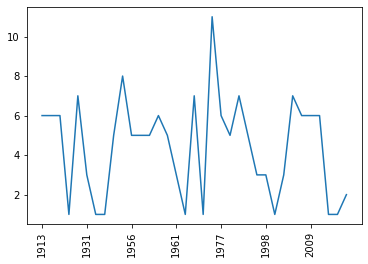

In [21]:
# Visualize
rec_years = json.loads(recommended_years(1))
line_labels = []
line_values = []
for i in range(len(rec_years)):
    line_labels.append(rec_years[i]['year'])
    line_values.append(rec_years[i]['measure'])
    
plt.plot(line_labels,line_values)
plt.xticks(range(len(rec_years))[0::5], list(line_labels)[0::5], rotation=90)
plt.show()

### Dashboard design

![alt text](img/dashboard_design.png)